# Convolution of incident energy spectrum

*Erik Hogenbirk, September 2016, ehogenbi@nikhef.nl*

Source code at https://github.com/XENON1T/PTB (notebook 13)

As shown by Jacques in his Jacques' note, (https://xecluster.lngs.infn.it/dokuwiki/lib/exe/fetch.php?media=xenon:xenon1t:jacques:mc_matching.html) we can get an incident spectrum of neutrons for the NE213, based on a few assumptions and some data from the CRC manual. In this notebook, I take this spectrum and apply the response fuction of the NE213, then scale it and compare it to the data. Both for background subtracted and background rejected data, the agreement is excellent, so that we should reconsider if we should do deconvolution at all.

In [1]:
from IPython.core.display import HTML
HTML("<style>.container { wdith:90% !important;}</style>")
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code"></form>''')

## Imports and reading data

In [2]:
# Import everything, including things like PTB data, the response function and necessary functions
%run '07b_deconvolution_definitions.ipynb'
import time
print('Computation of previous notebooks took %d seconds' % (time.clock()))

Computation of previous notebooks took 45 seconds


In [3]:
def read_simulation(fn):    
    # Relevant imports to reading in 
    import ROOT
    import root_numpy as rn

    # Actually read the root file
    f = ROOT.TFile(fn)
    treenames = rn.list_trees(fn)
    assert len(treenames) == 1
    tree = f.Get(treenames[0])
    data = rn.tree2array(tree)

    # Somehow the data is stored in the form of an array of tuples... wtf? So here's a hack to get it out!
    sim_energies = np.array([d[0] for d in data])
    print('Read a total of %d events from file %s.' % (len(sim_energies), fn))
    return sim_energies

In [4]:
fn = './simu/NE213_E_Spectrum.root'
sim_energies = read_simulation(fn)

Read a total of 104603 events from file ./simu/NE213_E_Spectrum.root.


### The energy distribution

In [5]:
# Compute initial energy distribution
# Code stolen from Jacques to get the initial energy dist.
recreate_dist = False

if recreate_dist:
    from tqdm import tqdm
    emission_prob = []
    energies = []
    for i in tqdm(range (0, 10000000)):
        x=np.random.ranf()
        x=2*x-1
        weight=(1+0.11787*x+0.58355*np.power(x,2)+-0.11353*np.power(x,3)+0.0422*np.power(x,4)+0.16359*np.power(x,5))
        energy=(2.46073+(0.24848*x+0.01282*np.power(x,2)+0.00031*np.power(x,3)))
        energies.append(energy)
        emission_prob.append(weight)
    pickle.dump((energies, emission_prob), open('mc_input_spectrum.pkl', 'wb'))
else:
    print('Reading distribution from file...')
    energies, emission_prob = pickle.load(open('mc_input_spectrum.pkl', 'rb'))
    print('Read %d (%.1f M) entries.' % (len(energies), len(energies)*1e-6))


Reading distribution from file...
Read 10000000 (10.0 M) entries.


In [6]:
# Here is a custom histogram fuction, which is necessary because of the uneven bin spacing in the convolution matrix.
def make_hist(bin_edges, vals, norm_bin = True):
    '''Build a histogram of vals with custom bin edges.
    vals must be cool with indexing such as vals[vals > 1] (try np.array)
    Normalizes by bin width as well.    
    Includes bin value to the left (i.e. half-open intervals)
    Recommended to check :)
    '''
    hist = []
    for i in range(len(bin_edges)-1):
        bin_left = bin_edges[i]
        bin_right = bin_edges[i+1]
        bin_width = bin_right - bin_left
        n_entries = len(vals[(vals >= bin_left) & (vals < bin_right)])
        if norm_bin:
            hist.append(n_entries / bin_width)
        else:
            hist.append(n_entries)# / bin_width)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    return bin_centers, np.array(hist)

In [7]:
x1, sim_spec = make_hist(1000*neutron_energies, sim_energies, norm_bin = True)
# append a zero so that we follow neutron_energies
# This might giva a ~ < 15 keV offset
sim_spec = np.concatenate([sim_spec, np.array([0])])

In Fig. 1, I show the distribution that we get from simulation, along with the initial distribution of the energy of neutrons at production in the plasma. This is the starting point for this notebook. Note that the scaling here is arbitrary, the comparison is just to show that the influence of scattering in the NG is highly relevant for us.

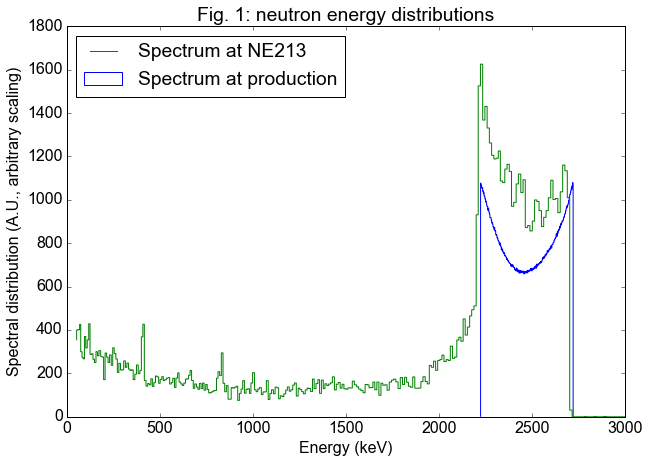

In [8]:
# Scaling factor
arbfac1 = 10
atne213, = plt.plot(neutron_energies * 1000, arbfac1*sim_spec, color='green', label='Spectrum at NE213',
                   ls='steps')
# Enable this line if you don't trust the make_hist function :)
#plt.hist(sim_energies, range=(0,3000), bins=300, histtype='step', label='Normal bins')
plt.hist(1000*np.array(energies), bins=300, histtype='step', 
         weights=0.02*np.array(emission_prob), #0.2 to sort of match the shapes of the distributions
                  label='Spectrum at production')
plt.xlim(0,3000)
plt.ylim(0,1800)
plt.xlabel('Energy (keV)')
plt.ylabel('Spectral distribution (A.U., arbitrary scaling)')
plt.title('Fig. 1: neutron energy distributions')
plt.legend(loc='upper left')
plt.show()


## Calculate convolution

First, let's get the detector response to an energy as given in Fig. 1. This is quite straightforward (and all the necessary functions are defined in previous notebooks); the result is shown in Fig. 2.

In [9]:
response_sim_spec = get_neutron_spectrum_custom_interpolated(e_scale, sim_spec)
response_sim_spec_r = get_neutron_spectrum_custom_interpolated(e_scale_r, sim_spec)

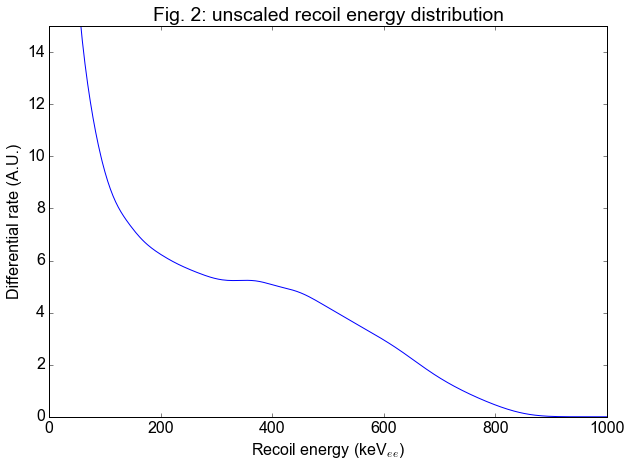

In [10]:
plt.plot(e_scale, response_sim_spec)
plt.xlim(0,1000)
plt.ylim(0,15)
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Differential rate (A.U.)')
plt.title('Fig. 2: unscaled recoil energy distribution')
plt.show()

## Scale (fit) to data

We now have the recoil spectrum corresponding to the simulated neutron energy spectrum, the only thing we have to do to compare this to data is *scale* the function. Other than this, the only tricky part is the low-energy cutoff. The high-energy cutoff of the fit should be at about 900 keV$_{ee}$, as I showed in a previous note.

### Fitter class

In [11]:
from iminuit import Minuit
class Fit1D:
    ''' x, y_data, y_err, y_model, acceptance = None'''
    limits = (-np.inf, np.inf)
    fit_options = dict(a = 1, errordef = 1, error_a = 1)
    m = None

    
    def __init__(self, x, y_data, y_err, y_model, acceptance = None):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err
        self.y_model = y_model
        self.sel = np.array([True for it in y_data])
        if acceptance == None:
            self.acc = np.array([1. for i in self.y_data])
        else:
            self.acc = acceptance
    
    def debug(self):
        print(len(self.x))
        print(len(self.y_data))
        print(len(self.y_err))
        print(len(self.y_model))        
        
    def set_limits(self, limits):
        self.limits = limits
        self.sel = (self.x >= limits[0]) & (self.x < limits[1])
        
    def chi2(self, a):
        return sum((self.y_data[self.sel] - a*self.acc[self.sel]*self.y_model[self.sel])**2 / 
                   (self.y_err[self.sel])**2) / (len(self.y_data[self.sel]) + 1)
        
    def fit(self):
        self.m = Minuit(self.chi2, **self.fit_options)
        self.m.migrad()
        
    def residuals(self):
        return (self.y_data - self.m.values['a']*self.acc*self.y_model) / self.y_err
    
    def residuals_abs(self):
        return (self.y_data - self.m.values['a']*self.acc*self.y_model)
    
    def plot(self):
        '''Plot a lot'''
        scale_factor = self.m.values['a']
        plt.plot(self.x, scale_factor * self.y_model * self.acc)
        plt.errorbar(self.x, self.y_data, self.y_err, ls='None', marker='.', markersize=5)
        for asdf in self.limits:
            plt.axvline(asdf, ls='--', color='red')
            
    def plot_data(self, **kwargs):
        plt.errorbar(self.x, self.y_data, self.y_err, **kwargs)
        
    def plot_fit(self, **kwargs):
        scale_factor = self.m.values['a']
        plt.plot(self.x, scale_factor * self.y_model * self.acc, **kwargs)
        
    def plot_limits(self):
        for asdf in self.limits:
            plt.axvline(asdf, ls='--', color='red')
            
    def plot_fit_no_acc(self, **kwargs):
        scale_factor = self.m.values['a']
        plt.plot(self.x, scale_factor * self.y_model, **kwargs)
        
    def plot_fit_custom_acc(self, acc, **kwargs):
        scale_factor = self.m.values['a']
        plt.plot(self.x, scale_factor * self.y_model * acc, **kwargs)
        
    def plot_fit_acc_plusminus(self, acc_min, acc_plus, **kwargs):
        scale_factor = self.m.values['a']
        ax = plt.gca()
        ax.fill_between(self.x, scale_factor * self.y_model * acc_plus, scale_factor * self.y_model * acc_min,
                       **kwargs)
        
    def plot_res(self, **kwargs):
        '''Plot the residuals. Also plot the +- 1 and 2 sigma lines'''
        plt.plot(self.x, self.residuals(), **kwargs)
        for asdf in self.limits:
            plt.axvline(asdf, ls='--', color='red')
        plt.axhline(0, color='black')
        for i in (-1,1):
            plt.axhline(i, color='gray', ls='--')
            plt.axhline(2*i, color='black', ls=':')
            
    def plot_res_abs(self, scaling=1., **kwargs):
        '''Plot the residuals. Also plot the +- 1 and 2 sigma lines'''
        plt.errorbar(self.x, scaling*self.residuals_abs(), scaling*self.y_err, **kwargs)

             
    def opt_chi2(self):
        return self.chi2(self.m.values['a'])

### Background rejected

#### Reminder: acceptance at low energy

For the background subtracted spectrum, we're limited by the acceptance on the low energy side. At low energy, the neutron and electronic recoil bands start to overlap. I have made a crude acceptance estimate shown in Fig. 3. I choose a fit range starting at 300 keV$_{ee}$, corresponding to an acceptance of about 89%.

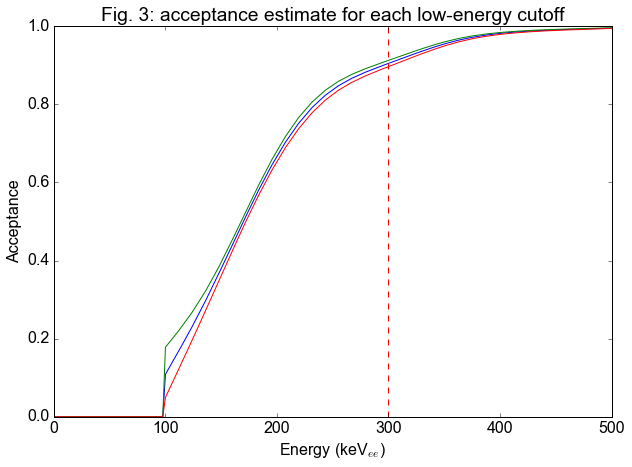

In [12]:
# acc_acceptances = np.array(acc_acceptances)
plt.plot(e_scale, acc_e)
plt.plot(e_scale, acc_e_plus)
plt.plot(e_scale, acc_e_min)

plt.axvline(300, color='red', ls='--')
plt.ylim(0,1)
plt.xlim(0,500)
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Acceptance')
plt.title('Fig. 3: acceptance estimate for each low-energy cutoff')
plt.show()

In [13]:
%%capture
# NO ACCEPTANCE CORRECTION
fit_disc_sub = Fit1D(e_scale, fg_disc_sub, fg_disc_sub_err, response_sim_spec)
fit_disc_sub.set_limits((300,900))
fit_disc_sub.fit()

In [14]:
%%capture
# YES ACCEPTANCE CORRECTION
fit_disc_sub_acc = Fit1D(e_scale, fg_disc_sub, fg_disc_sub_err, response_sim_spec, acc_e)
fit_disc_sub_acc.set_limits((120,900))
fit_disc_sub_acc.fit()

In [15]:
%%capture
# YES ACCEPTANCE CORRECTION AND ALSO REBINNED
fit_disc_sub_acc_r = Fit1D(e_scale_r, fg_disc_sub_r, fg_disc_sub_err_r, response_sim_spec_r, acc_e_r)
fit_disc_sub_acc_r.set_limits((120,900))
fit_disc_sub_acc_r.fit()

Fig. 4 shows the fit and the data for the best-fit scaling. The bottom panel shows the residuals in units of sigma, where by-eye I cannot see a systematic effect. 

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


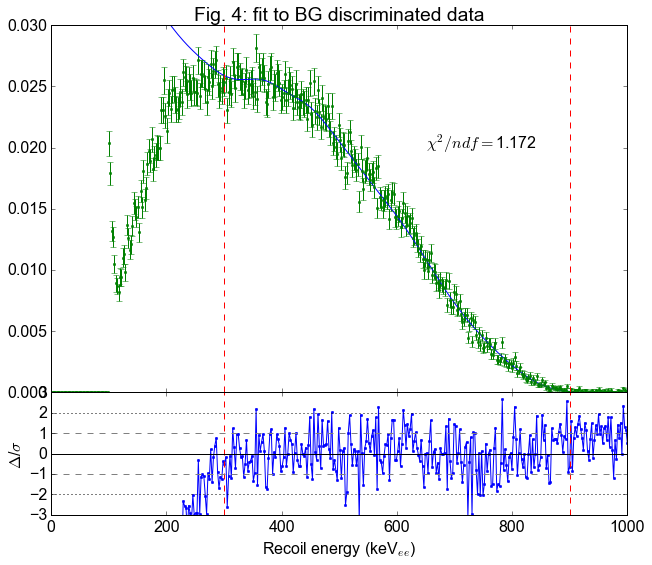

In [16]:
plt.figure(figsize=(10,8.5))
frame1=plt.gcf().add_axes((.1,.3,.8,.6))
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
fit_disc_sub.plot()
plt.xlim(0,1000)
plt.ylim(0,0.03)
plt.text(650, 0.02,'$\chi^2/ndf = $%.3f' % (fit_disc_sub.opt_chi2()))

frame2=plt.gcf().add_axes((.1,.1,.8,.2))   
fit_disc_sub.plot_res(color='blue', marker='.', markersize=5)
plt.ylabel('$\Delta$/$\sigma$')
plt.xlim(0,1000)
plt.ylim(-3,3)
plt.xlabel('Recoil energy (keV$_{ee}$)')

frame1.set_title('Fig. 4: fit to BG discriminated data')
plt.show()

### Paper figure

In [17]:
%run 'function_definitions.ipynb'

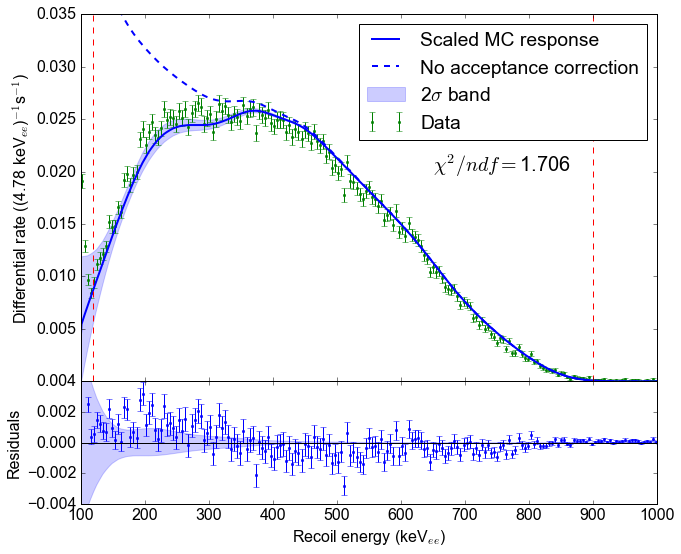

In [18]:
errs = 'abs'
#errs = 'rel'

plt.figure(figsize=(10,8.5))
# Top frame
frame1=plt.gcf().add_axes((.1,.3,.8,.6))
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame

# Plot fit
# fit_disc_sub_acc.plot_data(ls='None', marker='.', markersize=5, color='green', label='Data')
# fit_disc_sub_acc.plot_fit(color='blue', lw=2, label='Fit')
# fit_disc_sub_acc.plot_fit_no_acc(color='blue', lw=2, ls='--', label='No acceptance correction')
# fit_disc_sub_acc.plot_limits()
# fit_disc_sub_acc.plot_fit_acc_plusminus(acc_e_min, acc_e_plus, alpha=0.25)

# Plot fit
fit_disc_sub_acc_r.plot_data(ls='None', marker='.', markersize=5, color='green', label='Data')
fit_disc_sub_acc_r.plot_fit(color='blue', lw=2, label='Scaled MC response')
fit_disc_sub_acc_r.plot_fit_no_acc(color='blue', lw=2, ls='--', label='No acceptance correction')
fit_disc_sub_acc_r.plot_limits()
# fit_disc_sub_acc_r.plot_fit_acc_plusminus(acc_e_min_r, acc_e_plus_r, alpha=0.4, color='blue')
# fit_disc_sub_acc_r.plot_fit_acc_plusminus(acc_e_min2_r, acc_e_min_r, alpha=0.2, color='blue')
# fit_disc_sub_acc_r.plot_fit_acc_plusminus(acc_e_plus_r, acc_e_plus2_r, alpha=0.2, color='blue')
fit_disc_sub_acc_r.plot_fit_acc_plusminus(acc_e_min2_r, acc_e_plus2_r, alpha=0.2, color='blue', 
                                          label='2$\sigma$ band')

plt.ylim(0,0.035)
plt.yticks(np.arange(0.005,0.03501, 0.005))
plt.text(650, 0.02,'$\chi^2/ndf = $%.3f' % (fit_disc_sub_acc.opt_chi2()), size=20)
plt.xlim(100,1000)
plt.ylabel('Differential rate ((%.2f keV$_{ee}$)$^{-1}$s$^{-1}$)' % (2*p_scale_to_e_and[1]))

plt.legend()

frame2=plt.gcf().add_axes((.1,.1,.8,.2))   

# RELATIVE
if errs == 'rel':
    fit_disc_sub_acc_r.plot_res(color='blue', marker='.', markersize=5)
    plt.ylabel('$\Delta$/$\sigma$')
    plt.ylim(-3,3)

# ABSOLUTE
if errs == 'abs':    
    fit_disc_sub_acc_r.plot_res_abs(color='blue', marker='.', markersize=5, ls='None')
#     plt.fill_between(e_scale_r, 
#                     (fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_plus_r -
#                      fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_r),
#                      (fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_min_r - 
#                      fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_r)
#                     , color='blue', alpha=0.4)
#     plt.fill_between(e_scale_r, 
#                     (fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_plus_r -
#                      fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_r),
#                      (fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_plus2_r - 
#                      fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_r)
#                     , color='blue', alpha=0.2)
#     plt.fill_between(e_scale_r, 
#                     (fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_min_r -
#                      fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_r),
#                      (fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_min2_r - 
#                      fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_r)
#                     , color='blue', alpha=0.2)
    plt.fill_between(e_scale_r, 
                    (fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_plus2_r -
                     fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_r),
                     (fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_min2_r - 
                     fit_disc_sub_acc_r.m.values['a']*response_sim_spec_r*acc_e_r)
                    , color='blue', alpha=0.2)
    plt.ylabel('Residuals')
    plt.ylim(-0.004,0.004)
    plt.yticks(np.arange(-0.004,0.00401, 0.002))
    plt.axhline(0, color='black')




plt.xlim(100,1000)
plt.xlabel('Recoil energy (keV$_{ee}$)')

plt.savefig('./figs/fit_with_acc_r.png', bbox_inches='tight')
plt.savefig('./figs/fit_with_acc_r.pdf', bbox_inches='tight')
plt.show()

### BG subtracted

For the background subtracted spectrum, we can go even lower in energy. The lower threshold is eventually limited by the x-rays caused by the neutron generator (which are not in background, so we cannot subtract them). For the next plot, I take a cutoff of 150 keV$_{ee}$.

In [19]:
print('NOTE: TURNED OFF ')

NOTE: TURNED OFF 


In [20]:
# %%capture
# fit_sub = Fit1D(e_scale, fg_sub, fg_sub_err, response_sim_spec)
# fit_sub.set_limits((100,900))
# fit_sub.fit()

In [21]:
# plt.figure(figsize=(10,8.5))
# frame1=plt.gcf().add_axes((.1,.3,.8,.6))
# frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
# fit_sub.plot()
# plt.xlim(0,1000)
# plt.ylim(0,0.06)
# plt.text(650, 0.04,'$\chi^2/ndf = $%.3f' % (fit_sub.opt_chi2()))


# frame2=plt.gcf().add_axes((.1,.1,.8,.2))   
# fit_sub.plot_res(color='blue', marker='.', markersize=5)
# plt.ylabel('$\Delta$/$\sigma$')
# plt.xlim(0,1000)
# plt.ylim(-3,3)
# plt.xlabel('Recoil energy (keV$_{ee}$)')

# frame1.set_title('Fig. 4: fit to BG subtracted data')
# plt.show()

### Fit range dependence

In [22]:
%%capture
low_lim = np.linspace(100, 800, 100)
a = []
da = []
chi2 = []
for low_l in low_lim:
    f = Fit1D(e_scale, fg_disc_sub, fg_disc_sub_err, response_sim_spec, acc_e)
    f.set_limits((low_l,900))
    f.fit()
    _a = (f.m.values['a'])
    _da = f.m.errors['a']
    _chi2 = f.m.fval
    a.append(_a)
    da.append(_da)
    chi2.append(_chi2)
    

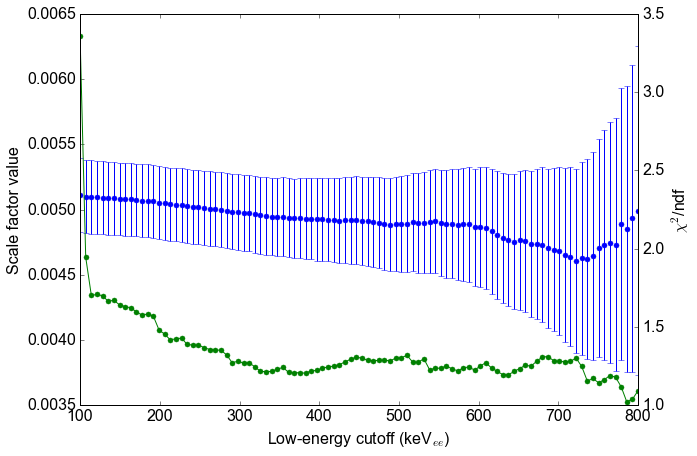

In [23]:
plt.errorbar(low_lim, a, da, marker='.', markersize=10, ls='None')
plt.xlabel('Low-energy cutoff (keV$_{ee}$)')
plt.ylabel('Scale factor value')
plt.twinx()
plt.plot(low_lim, chi2, color='green', marker='.', markersize=10)
plt.ylabel('$\chi^2$/ndf')

In [24]:
a_range = np.linspace(0.0035, 0.006, 120)
fancy_chi2 = []
Z = []
for low_l in low_lim:
    f = Fit1D(e_scale, fg_disc_sub, fg_disc_sub_err, response_sim_spec, acc_e)
    f.set_limits((low_l,900))
    _a_list = []
    for _a in a_range:
        _chi2 = f.chi2(_a)
        fancy_chi2.append(np.array([low_l, _a, _chi2]))
        _a_list.append(_chi2)
    Z.append(_a_list)
fancy_chi2 = np.array(fancy_chi2)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [25]:
%run 'plots.ipynb'

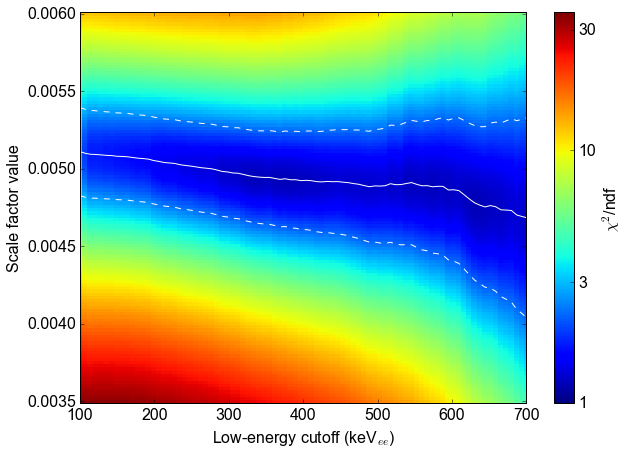

In [26]:
plot_hist2d(fancy_chi2[:,0], fancy_chi2[:,1], fancy_chi2[:,2], norm=LogNorm(), vmin=1)
#plt.errorbar(low_lim, a, da, marker='.', markersize=10, ls='None', color='white')
plt.plot(low_lim, a, color='white')
for bla in [-1,1]:
    plt.plot(low_lim, np.array(a) + bla*np.array(da), color='white', ls='--')
cb = plt.colorbar(ticks=[1,3,10,30], label='$\chi^2$/ndf')
cb.set_ticklabels([1,3,10,30])
plt.xlabel('Low-energy cutoff (keV$_{ee}$)')
plt.ylabel('Scale factor value')
plt.xlim(100,700)
plt.savefig('./plots/chi2_space.png', bbox_inches = 'tight')

## High energy

In [27]:
# PLACE HOLDER FOR HE
# fn_he = './simu/NE213_E_Spectrum.root'
# sim_energies_he = read_simulation(fn_he)

sim_energies_he = pickle.load(open('he_spec_lowstat.pkl', 'rb'))

In [28]:
x1, sim_spec_he = make_hist(1000*neutron_energies, sim_energies_he, norm_bin = True)
x1, sim_spec_he_14 = make_hist(1000*neutron_energies, np.array([14000. for i in range(len(sim_energies_he))]),
                               norm_bin = True)
# append a zero so that we follow neutron_energies
# This might giva a ~ < 15 keV offset
sim_spec_he = np.concatenate([sim_spec_he, np.array([0])])
sim_spec_he_14 = np.concatenate([sim_spec_he_14, np.array([0])])

In [29]:
len(sim_energies_he)

957

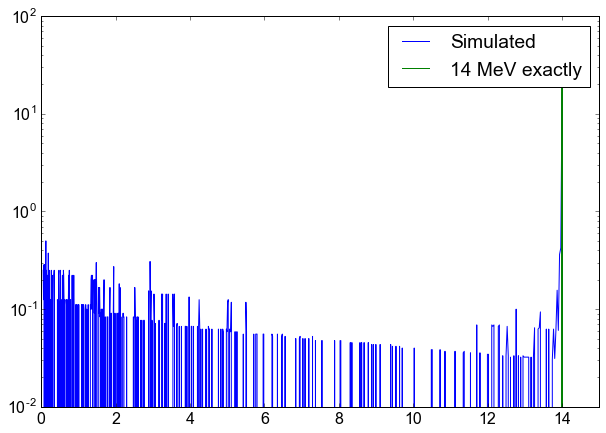

In [30]:
#plt.plot(x1, sim_spec_he)
plt.plot(neutron_energies, sim_spec_he, label='Simulated')
plt.plot(neutron_energies, sim_spec_he_14, label='14 MeV exactly')

plt.yscale('log')
plt.xlim(0,15)
#plt.hist(0.001*sim_energies_he, normed=True, bins=40)
plt.legend()
plt.show()

In [31]:
response_sim_spec_he = get_neutron_spectrum_custom_interpolated(e_scale_he, sim_spec_he)
response_sim_spec_he_14 = get_neutron_spectrum_custom_interpolated(e_scale_he, sim_spec_he_14)

In [32]:
%%capture
fit_he = Fit1D(e_scale_he, fg_he_sub_proper, fg_he_sub_err_proper, response_sim_spec_he)
fit_he.set_limits((1000,8500))
fit_he.fit()

In [33]:
%%capture
fit_he_14 = Fit1D(e_scale_he, fg_he_sub_proper, fg_he_sub_err_proper, response_sim_spec_he_14)
fit_he_14.set_limits((1000,8500))
fit_he_14.fit()

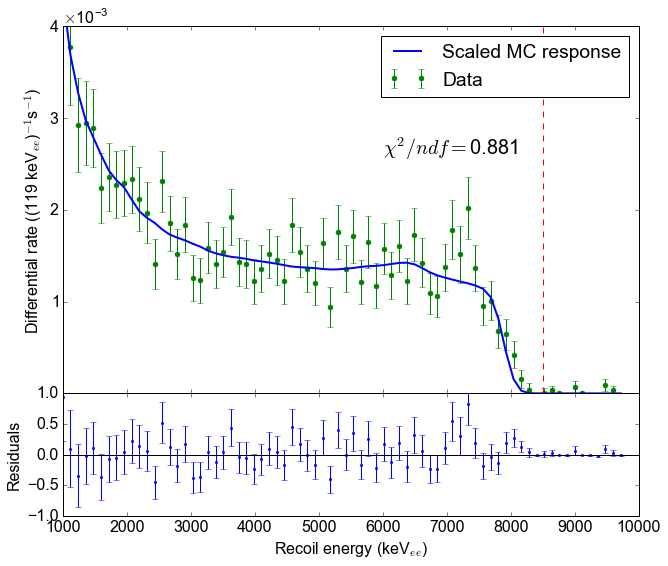

In [34]:
plt.figure(figsize=(10,8.5))
# Top frame
frame1=plt.gcf().add_axes((.1,.3,.8,.6))
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
fit_he.plot_data(color='green', markersize=10, marker='.', ls='None', label='Data')
fit_he.plot_fit(label='Scaled MC response', lw=2, color='blue')
fit_he.plot_limits()
plt.xlim(1000, 10000)
plt.ylim(0,0.004)
plt.ylabel('Differential rate ((119 keV$_{ee}$)$^{-1}$s$^{-1}$)')
plt.yticks(np.arange(0.001, 0.005, 0.001))
plt.text(6000, 0.0026,'$\chi^2/ndf = $%.3f' % (fit_he.opt_chi2()), size=20)
plt.legend()
ax = plt.gca()
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax.yaxis.major.formatter._useMathText = True

frame2=plt.gcf().add_axes((.1,.1,.8,.2))   
fit_he.plot_res_abs(scaling=1e3, marker='.',markersize=5, ls='None')
plt.axhline(0, color='black')
plt.ylim(-1,1)
plt.ylabel('Residuals')
plt.xlabel('Recoil energy (keV$_{ee}$)')


plt.savefig('./figs/he_spec.pdf', bbox_inches='tight')
plt.savefig('./figs/he_spec.png', bbox_inches='tight')
plt.show()

## Paper Plots

In [35]:
def int_spec(x, y, x_min = - np.inf, x_max = np.inf):
    sel = (x >= x_min) & (x < x_max)
    x = x[sel]
    y = y[sel]
    dx = np.diff(x)
    int_low = sum(dx*y[:-1])
    int_high = sum(dx*y[1:])
    print(int_low, int_high)
    return 0.5*(int_low + int_high)

In [36]:
e_and, y_and = read_flu('./PTB_DATA/160729_email_andreas/mx.flu')

In [37]:
def fill_between_steps(x, y1, y2=0, h_align='mid', ax=None, **kwargs):
    ''' Fills a hole in matplotlib: Fill_between for step plots.

    Parameters :
    ------------

    x : array-like
        Array/vector of index values. These are assumed to be equally-spaced.
        If not, the result will probably look weird...
    y1 : array-like
        Array/vector of values to be filled under.
    y2 : array-Like
        Array/vector or bottom values for filled area. Default is 0.

    **kwargs will be passed to the matplotlib fill_between() function.

    '''
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:]
    # Now: the average x binwidth
    xstep = (x[1:] - x[:-1]).mean()
    # Now: add one step at end of row.
    xx = np.append(xx, xx.max() + xstep)

    # Make it possible to change step alignment.
    if h_align == 'mid':
        xx -= xstep / 2.
    elif h_align == 'right':
        xx -= xstep

    # Also, duplicate each y coordinate in both arrays
    y1 = y1.repeat(2)
    if type(y2) == np.ndarray:
        y2 = y2.repeat(2)

    # now to the plotting part:
    return ax.fill_between(xx, y1, y2=y2, **kwargs)

52769.0 53451.0664336
522.211277764 515.212599737
0.926592413918 0.944182512879


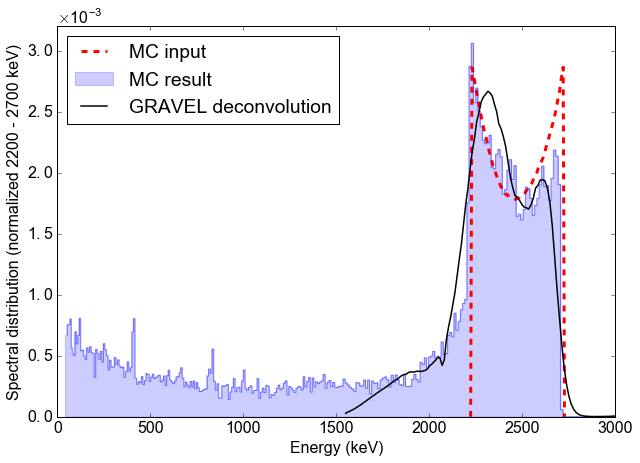

In [38]:
hist_mc, e_mc_edges = np.histogram(1000*np.array(energies), bins=70, 
         weights=np.array(emission_prob), normed=True)
e_mc = 0.5*(e_mc_edges[1:] + e_mc_edges[:-1])
e_mc_bin = np.diff(e_mc)[0]
e_mc = np.concatenate(( np.array([e_mc[0]-e_mc_bin]) , e_mc, np.array([e_mc[-1]+e_mc_bin])), axis=0)
hist_mc = np.concatenate((np.array([0]), hist_mc, np.array([0])))

# Scaling factor
int1 = int_spec(1000*neutron_energies, sim_spec,2200, 2700)# 2224.7600012558948, 2722.339434928938)
int2 = int_spec(1000*e_and, y_and, 2200, 2700)#2224.7600012558948, 2722.339434928938)
int3 = int_spec(e_mc, hist_mc, 2200, 2700)

plt.plot(e_mc, 1/int3*hist_mc, ls = '--', lw=3, color='red', label='MC input')
plt.plot(neutron_energies * 1000, 1/int1*sim_spec, ls='steps', alpha=0.4, color='blue')
fill_between_steps(neutron_energies * 1000,np.array([0 for _ in range(len(neutron_energies))])
                   , 1/int1*sim_spec, label='MC result', alpha=0.2, color='blue')

plt.plot(1000*e_and, 1/int2*y_and, color='black', lw=1.5, label='GRAVEL deconvolution',
        )

ax = plt.gca()
handles, labels =  ax.get_legend_handles_labels()
# Sort
labels = [labels[0], labels[2], labels[1]]
handles = [handles[0], handles[2], handles[1]]

ax.legend(handles, labels, loc='upper left')
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax.yaxis.major.formatter._useMathText = True

#plt.plot(1000*e_and, 1/int2*y_and, color='black', ls='solid', lw=0.5)

plt.xlim(0,3000)
plt.ylim(0,0.0032)
plt.xlabel('Energy (keV)')
plt.ylabel('Spectral distribution (normalized 2200 - 2700 keV)')
plt.savefig('./figs/mc_spectrum.png', bbox_inches='tight')
plt.savefig('./figs/mc_spectrum.pdf', bbox_inches='tight')
plt.show()

In [39]:
handles

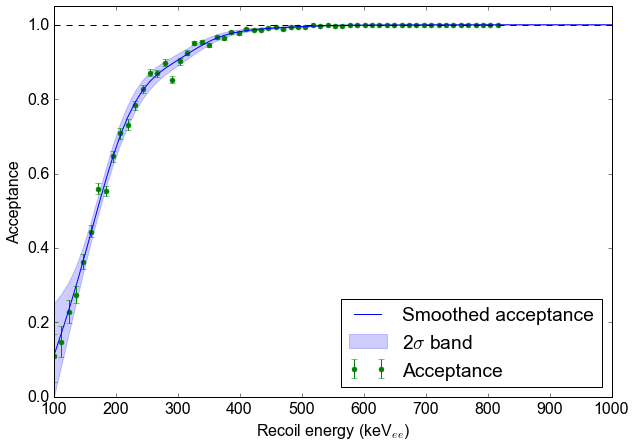

In [40]:
xmin, xmax= (100, 1000)
show_2sig_only = True

plt.errorbar(x_acc, y_acc, (dy_acc_plus, dy_acc_min), marker='.', markersize=10, ls='None', label='Acceptance', 
            color='green')
plt.plot(e_scale, acc_e, label='Smoothed acceptance', color='blue')
if show_2sig_only:
    # Only the 2sigma band
    plt.fill_between(e_scale, acc_e_plus2, acc_e_min2, label='2$\sigma$ band', alpha=0.2, color='blue')
else:
    # 1 and 2 sigma band
    plt.fill_between(e_scale, acc_e_plus, acc_e_min, label='1$\sigma$ band', alpha=0.4, color='blue')
    plt.fill_between(e_scale, acc_e_plus2, acc_e_plus, label='2$\sigma$ band', alpha=0.2, color='blue')
    plt.fill_between(e_scale, acc_e_min2, acc_e_min, alpha=0.2, color='blue')

plt.xlim(xmin, xmax)
plt.ylim(0,1.05)
plt.axhline(1, color='black', ls='--')
plt.legend(loc='lower right')
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Acceptance')

plt.savefig('./figs/acceptance.pdf', bbox_inches='tight')
plt.savefig('./figs/acceptance.png', bbox_inches='tight')

In [41]:
e_scale[350]

821.30000000000007

### Presentation plots

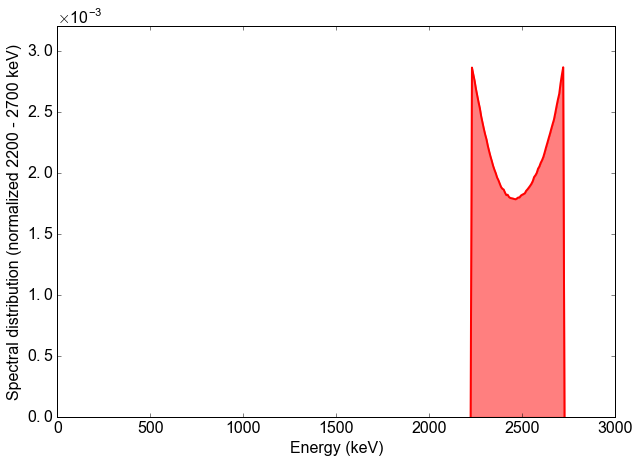

In [59]:
plt.plot(e_mc, 1/int3*hist_mc, ls = 'solid', lw=2, color='red', label='MC input')
plt.fill_between(e_mc, 0,  1/int3*hist_mc, color='red', alpha=0.5)

ax = plt.gca()
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax.yaxis.major.formatter._useMathText = True

plt.xlim(0,3000)
plt.ylim(0,0.0032)
plt.xlabel('Energy (keV)')
plt.ylabel('Spectral distribution (normalized 2200 - 2700 keV)')
plt.savefig('./figs/pres_0.png', bbox_inches='tight')
plt.savefig('./figs/pres_0.pdf', bbox_inches='tight')
plt.show()

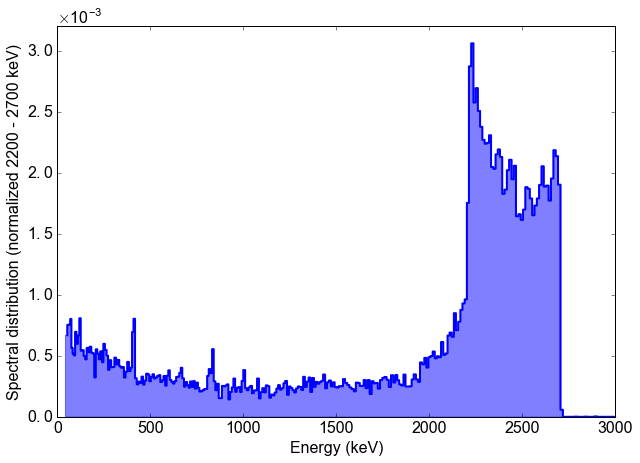

In [60]:
plt.plot(neutron_energies * 1000,1/int1*sim_spec, ls='steps', lw=2)
fill_between_steps(neutron_energies * 1000,np.array([0 for _ in range(len(neutron_energies))])
                   , 1/int1*sim_spec, label='MC result', alpha=0.5, color='blue')

ax = plt.gca()
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax.yaxis.major.formatter._useMathText = True

plt.xlim(0,3000)
plt.ylim(0,0.0032)
plt.xlabel('Energy (keV)')
plt.ylabel('Spectral distribution (normalized 2200 - 2700 keV)')
plt.savefig('./figs/pres_1.png', bbox_inches='tight')
plt.savefig('./figs/pres_1.pdf', bbox_inches='tight')
plt.show()

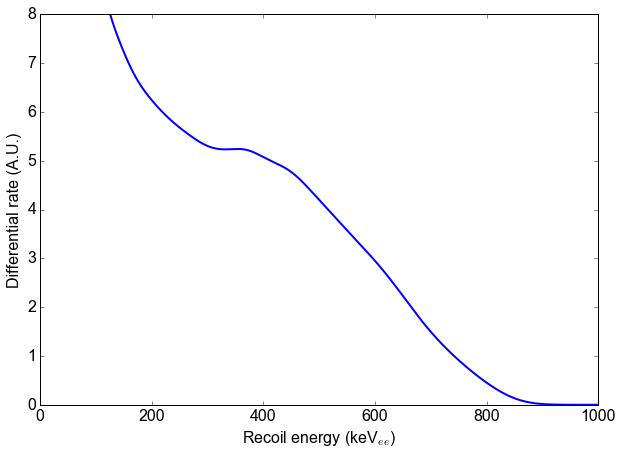

In [65]:
plt.plot(e_scale, response_sim_spec, lw=2)
plt.xlim(0,1000)
plt.ylim(0,8)
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Differential rate (A.U.)')
plt.savefig('./figs/pres_2.png', bbox_inches='tight')
plt.savefig('./figs/pres_2.pdf', bbox_inches='tight')
plt.show()

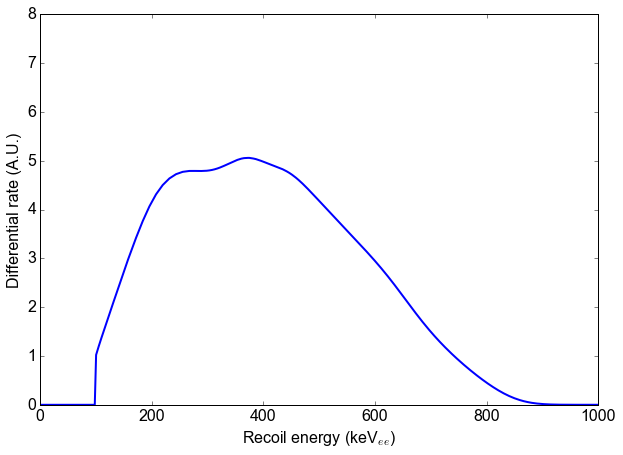

In [64]:
plt.plot(e_scale, acc_e* response_sim_spec, lw=2)
plt.xlim(0,1000)
plt.ylim(0,8)
plt.xlabel('Recoil energy (keV$_{ee}$)')
plt.ylabel('Differential rate (A.U.)')
plt.savefig('./figs/pres_3.png', bbox_inches='tight')
plt.savefig('./figs/pres_3.pdf', bbox_inches='tight')
plt.show()

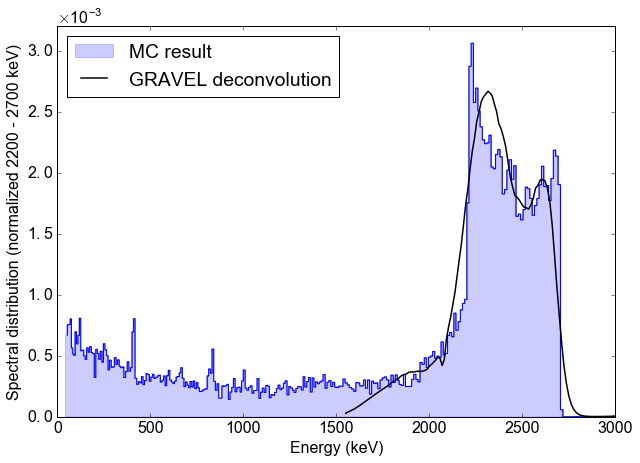

In [71]:
#plt.plot(e_mc, 1/int3*hist_mc, ls = '--', lw=3, color='red', label='MC input')
plt.plot(neutron_energies * 1000, 1/int1*sim_spec, ls='steps', alpha=0.4, color='blue')
fill_between_steps(neutron_energies * 1000,np.array([0 for _ in range(len(neutron_energies))])
                   , 1/int1*sim_spec, label='MC result', alpha=0.2, color='blue')
plt.plot(neutron_energies * 1000, 1/int1*sim_spec, lw=1, color='blue', ls='steps')

plt.plot(1000*e_and, 1/int2*y_and, color='black', lw=1.5, label='GRAVEL deconvolution',
        )

ax = plt.gca()
handles, labels =  ax.get_legend_handles_labels()
# Sort
labels = [labels[1], labels[0]]
handles = [handles[1], handles[0]]

ax.legend(handles, labels, loc='upper left')
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax.yaxis.major.formatter._useMathText = True

#plt.plot(1000*e_and, 1/int2*y_and, color='black', ls='solid', lw=0.5)

plt.xlim(0,3000)
plt.ylim(0,0.0032)
plt.xlabel('Energy (keV)')
plt.ylabel('Spectral distribution (normalized 2200 - 2700 keV)')
plt.savefig('./figs/pres_4.png', bbox_inches='tight')
plt.savefig('./figs/pres_4.pdf', bbox_inches='tight')
plt.show()